In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [4]:
dataset_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [5]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
dataset_df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [7]:
# Fill missing values in LotFrontage based on median LotFrontage by Neighborhood
dataset_df['LotFrontage'] = dataset_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Check if there are any missing values left in LotFrontage
print(dataset_df['LotFrontage'].isnull().sum())


0


In [8]:
# Fill missing values for numerical features with the median
for col in dataset_df.select_dtypes(include=['float64', 'int64']).columns:
    dataset_df[col].fillna(dataset_df[col].median(), inplace=True)

# Fill missing values for categorical features with the mode
for col in dataset_df.select_dtypes(include=['object']).columns:
    dataset_df[col].fillna(dataset_df[col].mode()[0], inplace=True)


/tmp/ipykernel_17/2687974756.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset_df[col].fillna(dataset_df[col].median(), inplace=True)
/tmp/ipykernel_17/2687974756.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [9]:
#Create a new feature for the total square footage
dataset_df['TotalSF'] = dataset_df['TotalBsmtSF'] + dataset_df['1stFlrSF'] + dataset_df['2ndFlrSF']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


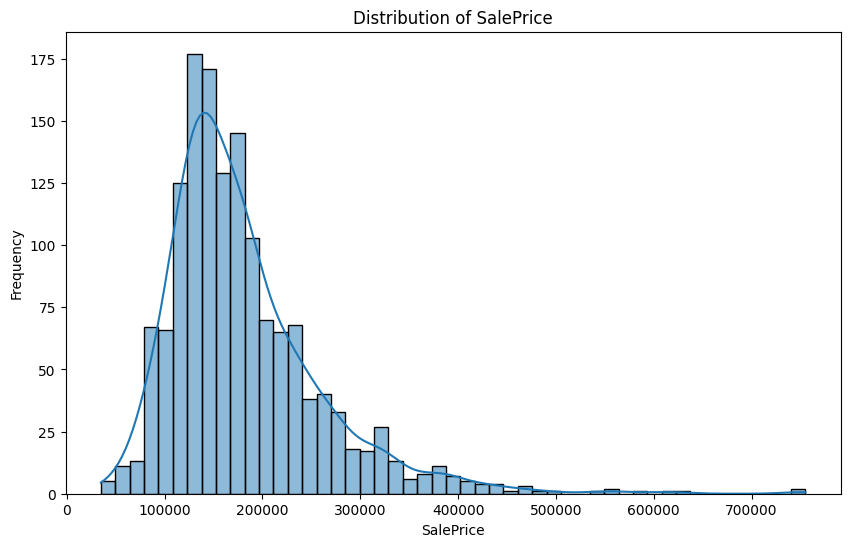

In [10]:
##Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(dataset_df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()


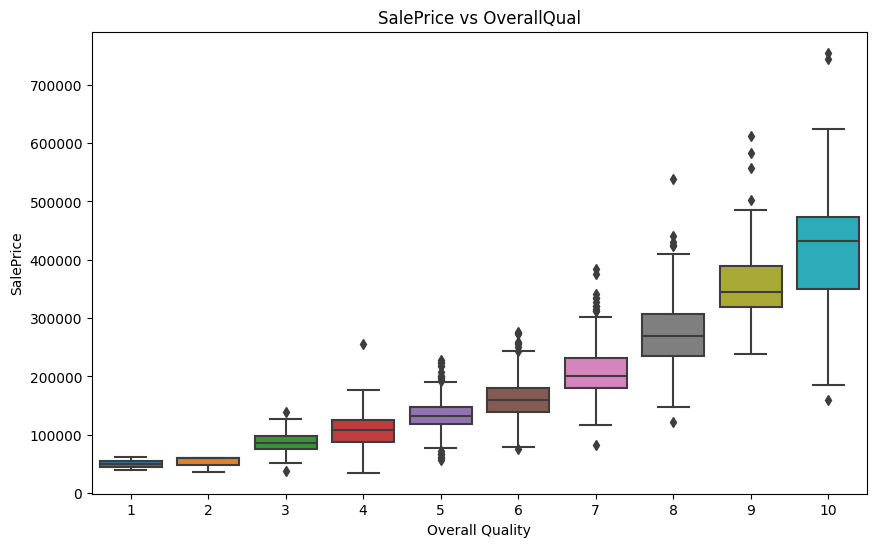

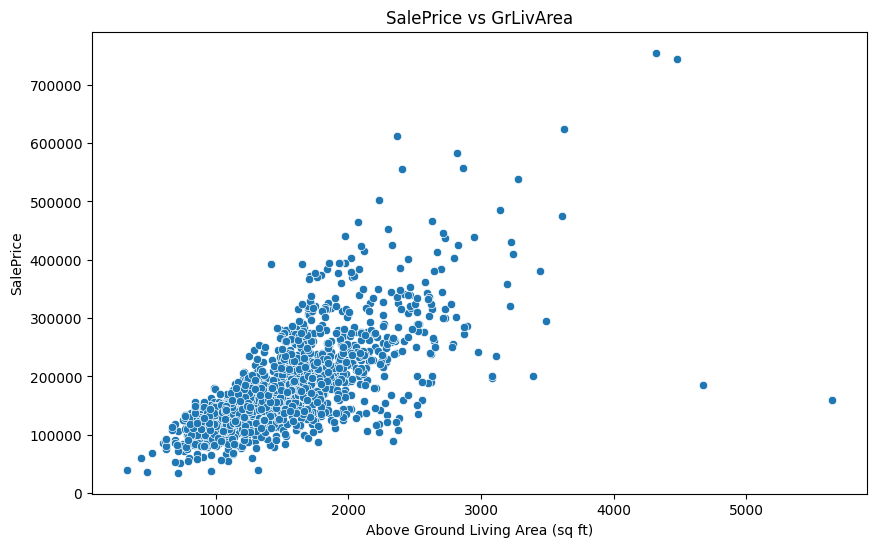

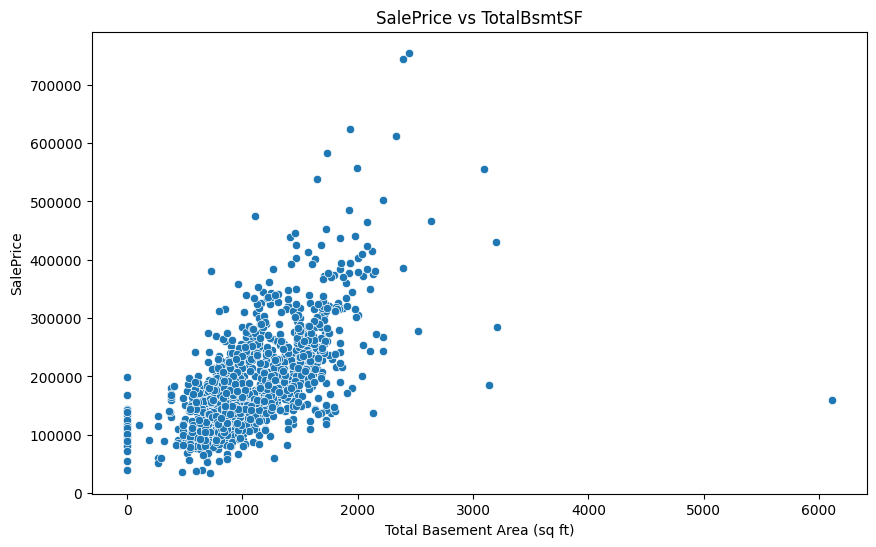

In [11]:
# Plot SalePrice vs OverallQual
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=dataset_df)
plt.title('SalePrice vs OverallQual')
plt.xlabel('Overall Quality')
plt.ylabel('SalePrice')
plt.show()

# Plot SalePrice vs GrLivArea
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=dataset_df)
plt.title('SalePrice vs GrLivArea')
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('SalePrice')
plt.show()

# Plot SalePrice vs TotalBsmtSF
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=dataset_df)
plt.title('SalePrice vs TotalBsmtSF')
plt.xlabel('Total Basement Area (sq ft)')
plt.ylabel('SalePrice')
plt.show()


In [12]:
# Import necessary library
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns
categorical_cols = dataset_df.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the categorical columns
dataset_df = pd.get_dummies(dataset_df, columns=categorical_cols)

# Compute the correlation matrix
corr_matrix = dataset_df.corr()

# Get the top 10 features most correlated with SalePrice
top_corr_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(10)
print(top_corr_features)


SalePrice      1.000000
OverallQual    0.790982
TotalSF        0.782260
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
BsmtQual_Ex    0.553105
Name: SalePrice, dtype: float64


In [13]:
##Split Data

from sklearn.model_selection import train_test_split

# Define the feature set (X) and the target variable (y)
X = dataset_df.drop(columns='SalePrice')
y = dataset_df['SalePrice']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (1168, 289)
Testing set size: (292, 289)


In [14]:
##Baseline Model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Create and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Calculate RMSE for training and testing sets
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test_pred, y_test))

print(f"Linear Regression Training RMSE: {train_rmse}")
print(f"Linear Regression Testing RMSE: {test_rmse}")


Linear Regression Training RMSE: 19552.818725745452
Linear Regression Testing RMSE: 29575.592680899303


In [15]:
##Random Forest

from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate RMSE for training and testing sets
train_rmse_rf = np.sqrt(mean_squared_error(y_train_pred_rf, y_train))
test_rmse_rf = np.sqrt(mean_squared_error(y_test_pred_rf, y_test))

print(f"Random Forest Training RMSE: {train_rmse_rf}")
print(f"Random Forest Testing RMSE: {test_rmse_rf}")


Random Forest Training RMSE: 10752.416145757168
Random Forest Testing RMSE: 29772.687248208895


In [16]:
##Gradient Boosting

from xgboost import XGBRegressor

# Create and train the Gradient Boosting model
gb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Calculate RMSE for training and testing sets
train_rmse_gb = np.sqrt(mean_squared_error(y_train_pred_gb, y_train))
test_rmse_gb = np.sqrt(mean_squared_error(y_test_pred_gb, y_test))

print(f"Gradient Boosting Training RMSE: {train_rmse_gb}")
print(f"Gradient Boosting Testing RMSE: {test_rmse_gb}")

Gradient Boosting Training RMSE: 5051.851740294405
Gradient Boosting Testing RMSE: 26360.155477393713


In [17]:
##Metric Calculation

from sklearn.metrics import mean_squared_error
import numpy as np

# Log-transform the target variable
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Predict and log-transform the predictions
y_train_pred_log = np.log1p(linear_model.predict(X_train))
y_test_pred_log = np.log1p(linear_model.predict(X_test))

# Calculate RMSE for log-transformed predictions
train_rmse_log = np.sqrt(mean_squared_error(y_train_log, y_train_pred_log))
test_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_test_pred_log))

print(f"Linear Regression Training RMSE (Log-transformed): {train_rmse_log}")
print(f"Linear Regression Testing RMSE (Log-transformed): {test_rmse_log}")


Linear Regression Training RMSE (Log-transformed): 0.10540109329259868
Linear Regression Testing RMSE (Log-transformed): 0.18864971595963703


In [18]:
##Cross-Validation

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the log-transformed target variable
cv_scores = cross_val_score(linear_model, X, np.log1p(y), cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE (Log-transformed): {cv_rmse}")
print(f"Mean Cross-Validation RMSE (Log-transformed): {cv_rmse.mean()}")


Cross-Validation RMSE (Log-transformed): [1.37498406e-01 1.91022630e+04 1.68430264e-01 3.42100409e+03
 1.99102806e-01]
Mean Cross-Validation RMSE (Log-transformed): 4504.75443499092


In [19]:
##Generate Predictions

# Predict the SalePrice for the test set
test_predictions_log = linear_model.predict(X_test)
print("Log Predictions:", test_predictions_log[:10])

# Clip predictions to a reasonable range before applying the exponential transformation
test_predictions_log = np.clip(test_predictions_log, a_min=None, a_max=20)
print("Clipped Log Predictions:", test_predictions_log[:10])

# Transform predictions back to the original scale
test_predictions = np.expm1(test_predictions_log)
print("Transformed Predictions:", test_predictions[:10])


Log Predictions: [157901.19536072 349380.04919395  86560.51931448 174400.42520251
 317159.17069049  66744.05990606 235901.13991814 146281.42521377
  57630.04995032 153867.07366614]
Clipped Log Predictions: [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
Transformed Predictions: [4.85165194e+08 4.85165194e+08 4.85165194e+08 4.85165194e+08
 4.85165194e+08 4.85165194e+08 4.85165194e+08 4.85165194e+08
 4.85165194e+08 4.85165194e+08]


In [20]:
##Create Submission File

# Create a DataFrame with the test set IDs and the predicted SalePrice
submission = pd.DataFrame({
    'Id': X_test.index,   
    'SalePrice': test_predictions
})

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

# Verify the contents of the submission file
print(submission.head())


     Id     SalePrice
0   892  4.851652e+08
1  1105  4.851652e+08
2   413  4.851652e+08
3   522  4.851652e+08
4  1036  4.851652e+08
